In [1]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib import cm
import time

## Generalidades
Creacion del current working directory, grafo G, vector con delfines y correspondiente vector de generos.
Creacion del layout que se va a usar en todo el notebook (<i>pos</i>) y visualizacion del grafo con el atributo <i>genero</i>.

In [2]:
carpeta = os.getcwd()+'/'

G = nx.read_gml(carpeta+'dolphins.gml')

gender = pd.read_csv(carpeta+'dolphinsGender.txt', sep='\t', header=None)
delfines = gender[0] # nombres de delfines (nodos)
genero = gender[1]   # genero de los delfines en el mismo orden que los nodos

# A cada uno de los nodos ya existentes en el grafo, se le agrega el genero
for d,g in zip(delfines,genero):
    G.add_node(d, gender=g)
    
# Tengo el grafo G con los delfines, enlaces, y atributo genero

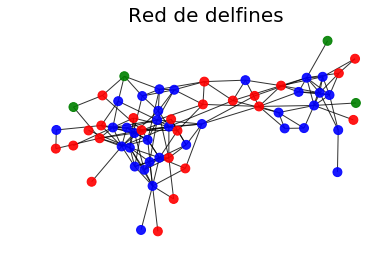

In [3]:
# Grafico de la red con su atributo genero como colores
pos = nx.spring_layout(G) # posicion de los nodos que se va a usar en todo el notebook

# Nodos
nx.draw_networkx_nodes(G,pos,nodelist=G.nodes(),
                       node_color=["blue" if g=="m" else "red" if g=="f" else "green" for g in nx.get_node_attributes(G, "gender").values()],
                       with_labels=False,node_size=80,alpha=0.9)

# Enlaces
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.8)

#Etiquetas
plt.title('Red de delfines',fontsize=20)
plt.axis('off')
plt.show()

# Comunidades
Creacion de comunidades usando el algoritmo Girvan Newman. Por defecto, lo hace eliminando enlaces segun edge betweenness. Solo devuelve las comunidades, no los enlaces que elimina en cada paso.

In [4]:
# Creo las comunidades 
com = nx.algorithms.community.centrality.girvan_newman(G) # com es un generador

a = [node for node in com] # a es una lista (de listas) de comunidades

# El primer elemento a[0] es una lista con dos elementos correspondiente a la primera división,
# y así va aumentando hasta que el último elemento a[60] son 62 comunidades de un delfin cada una.

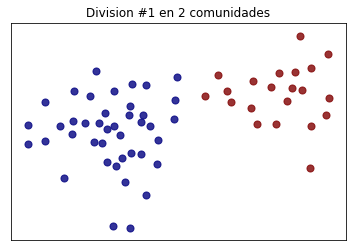

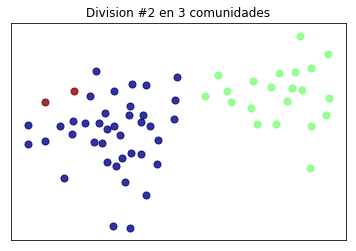

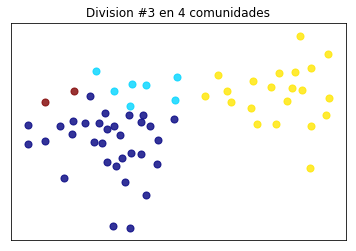

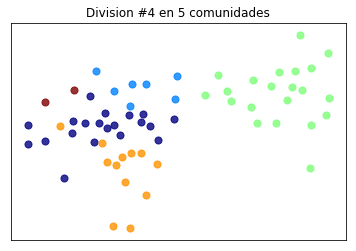

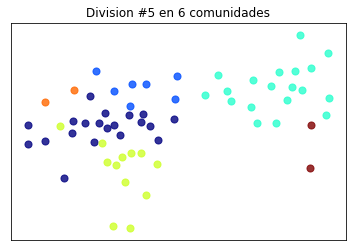

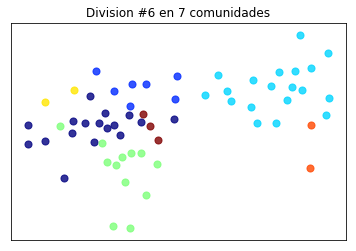

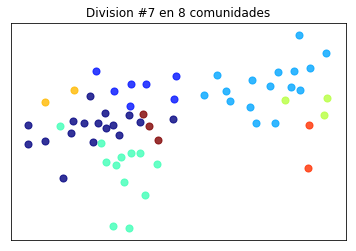

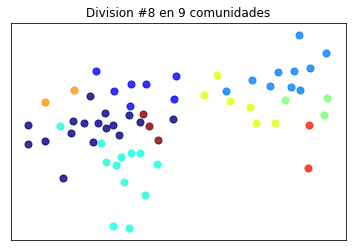

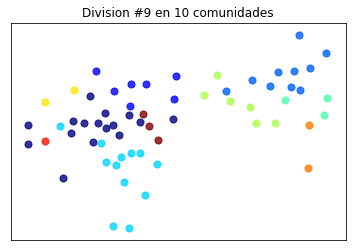

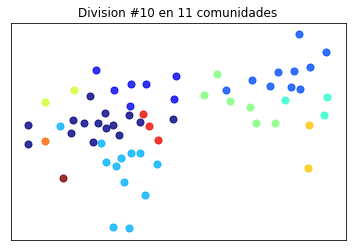

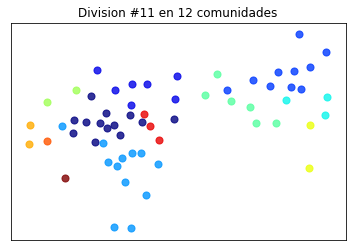

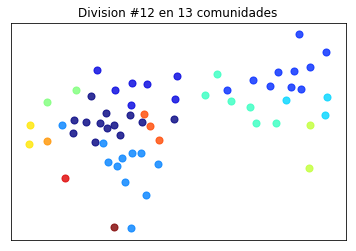

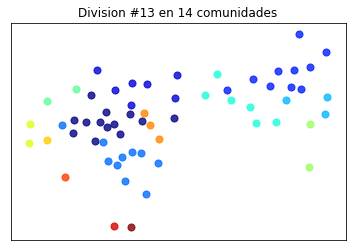

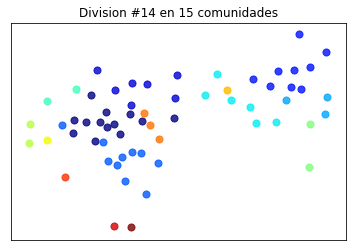

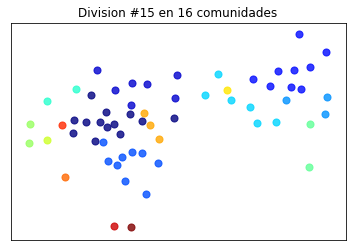

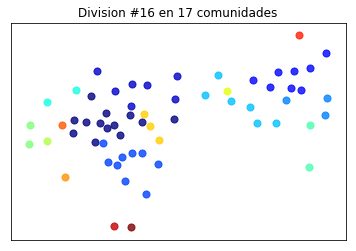

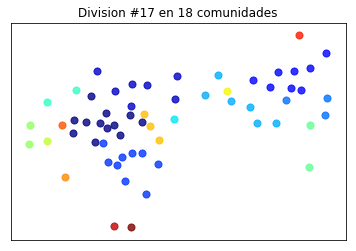

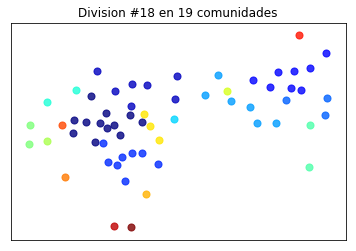

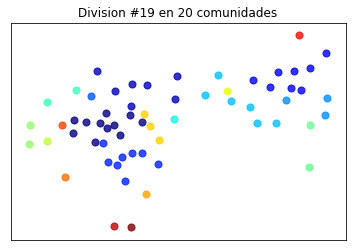

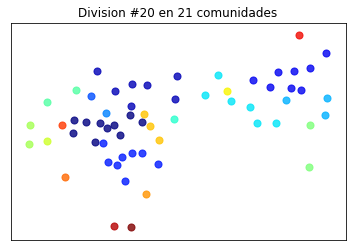

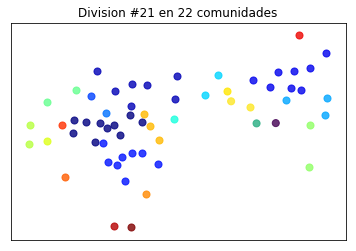

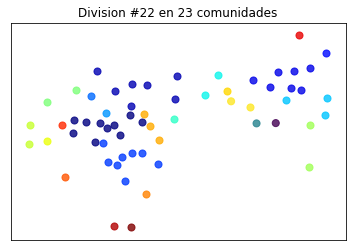

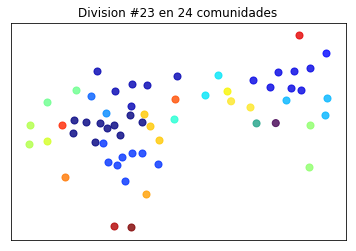

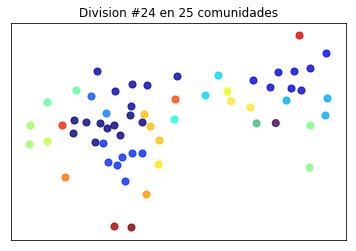

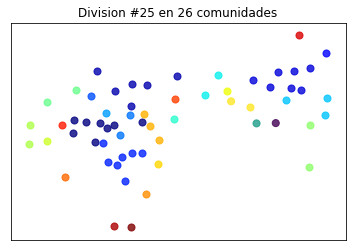

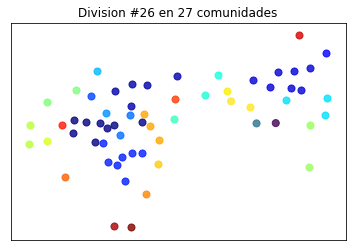

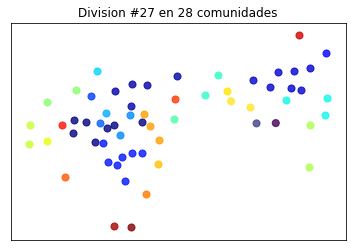

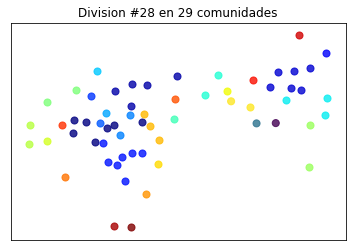

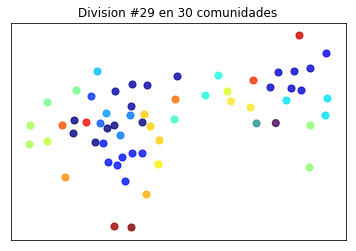

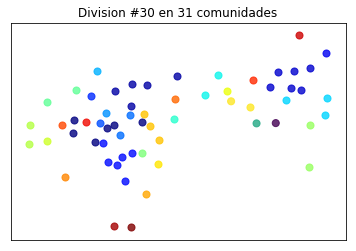

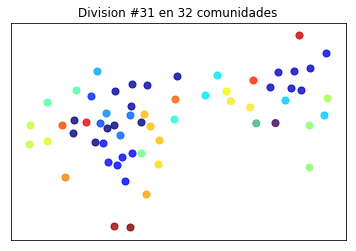

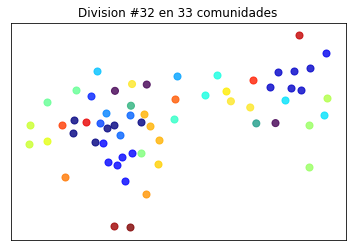

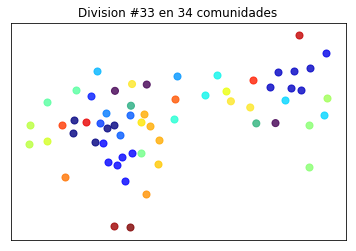

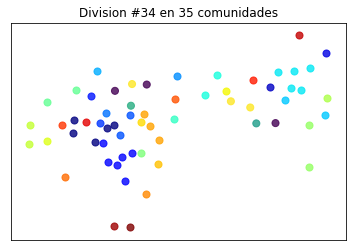

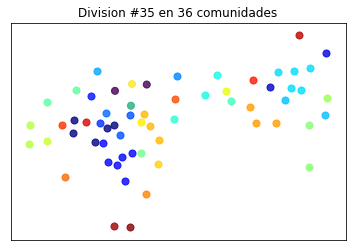

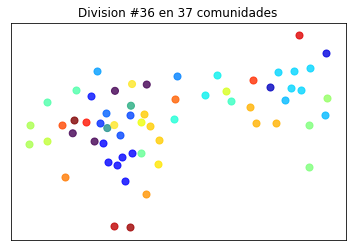

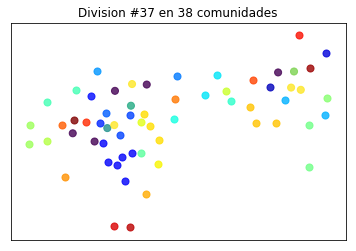

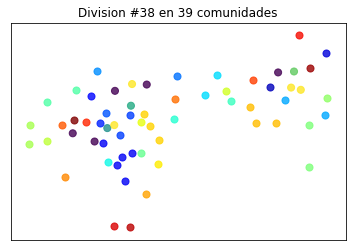

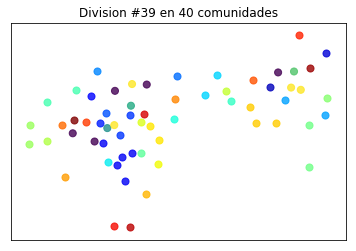

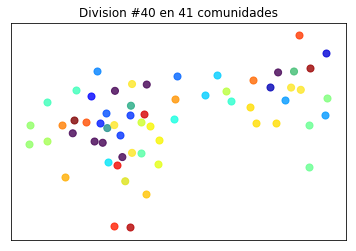

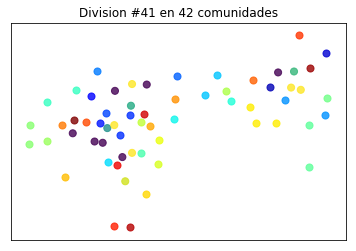

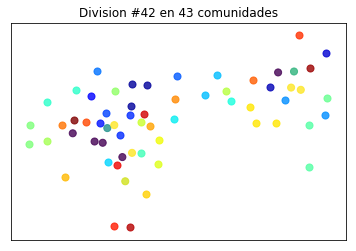

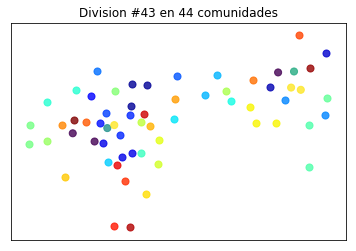

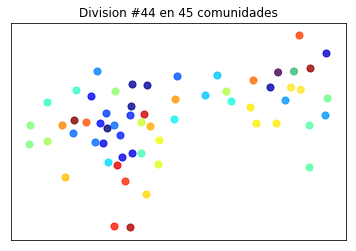

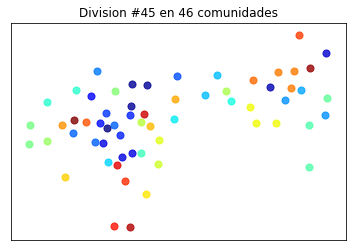

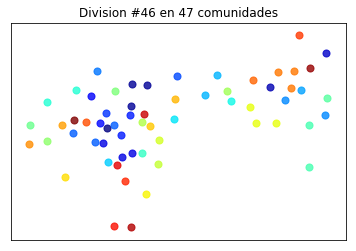

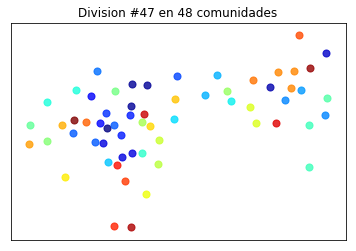

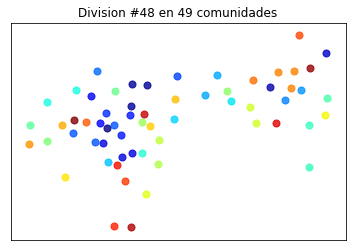

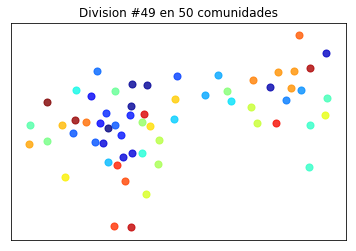

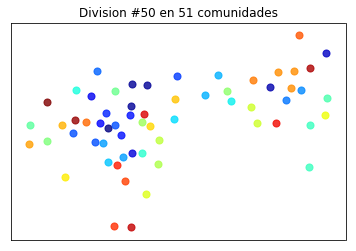

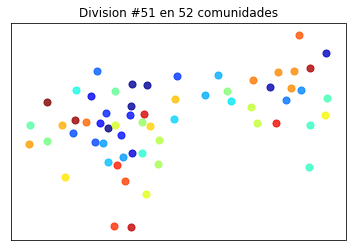

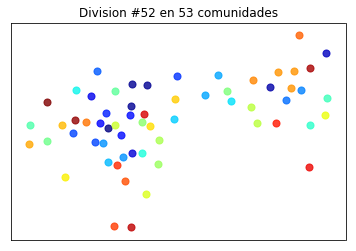

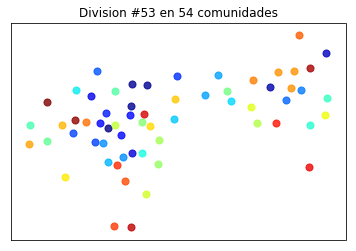

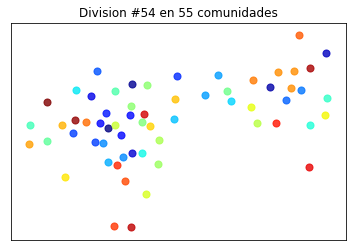

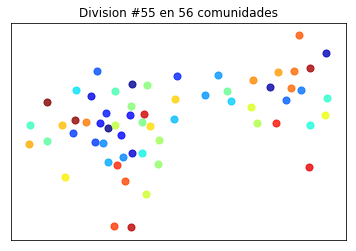

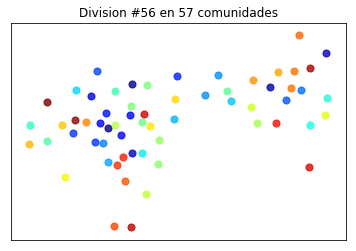

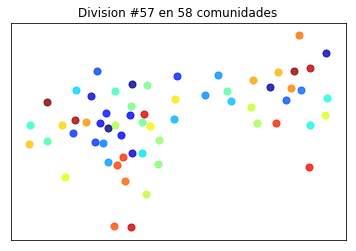

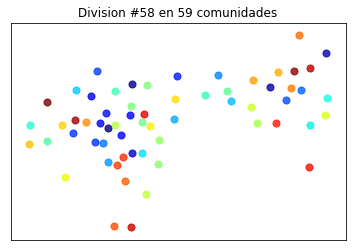

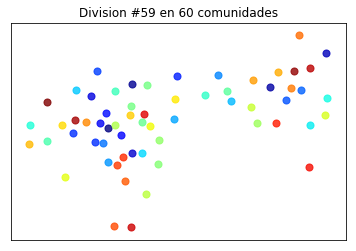

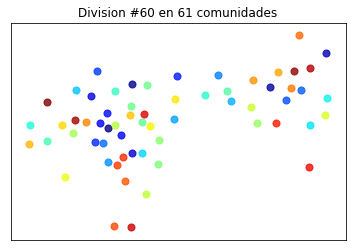

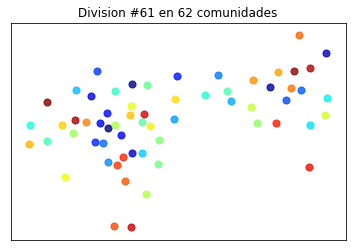

In [5]:
# Para graficar las comunidades por colores, sin enlaces (o con todos los enlaces)
# En cada paso crea un grafico distinto

it = len(a) # Cantidad de pasos o cantidad de divisiones

for j in range(it):
    coms = a[j] # Elijo un paso de a 
    N = len(coms) # Cantidad de comunidades en ese paso
    colores_com = np.linspace(0,1,N) # quiero N colores, uno por comunidad
    colores = [ cm.jet(x) for x in colores_com ] # transformo en colores del colormap que quiera
    
    for i in range(N):
        nx.draw_networkx_nodes(G,pos,nodelist=coms[i],
                               node_color=colores[i],with_labels=False,node_size=50,alpha=0.8)
        # Para cada comunidad, dibujo sus nodos con un unico color del vector colores
        #nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.8) # Si quiero ver todos los enlaces
    plt.title('Division #'+str(j+1)+' en '+str(N)+' comunidades')
    plt.xticks([])
    plt.yticks([])
    plt.show()

# colormaps que mejor se ven: plasma, gist_rainbow, jet

Visualizacion mas clara de la division: animacion. Se puede usar animation de matplotlib o se puede crear un loop que grafique sobreescribiendo el anterior.

In [6]:
# Para animarlo. En mi pc no funciona animation así que no sé si está bien escrito
from matplotlib import animation

def animacion(j,a,G):
    coms = a[j]
    N = len(coms) # Cantidad de nodos en la comunidad
    colores_com = np.linspace(0,1,N) # quiero N colores, uno por comunidad
    colores = [ cm.jet(x) for x in colores_com ] # transformo en colores del colormap
    for i in range(N):
        grafo = nx.draw_networkx_nodes(G,pos,nodelist=coms[i],
                               node_color=colores[i],with_labels=False,node_size=50,alpha=0.8)
    return grafo,

numframes = len(a)
fig = plt.figure()
anim = animation.FuncAnimation(fig, animacion, frames=numframes,
                              fargs=(a,G),interval=100) #blit=True means only re-draw the parts that have changed.
plt.show()

#anim.save('nodos.mp4', fps=30)


<Figure size 432x288 with 0 Axes>

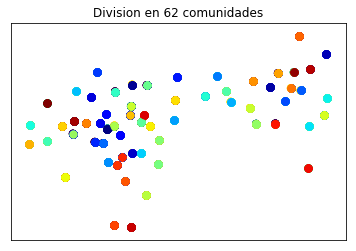

In [7]:
# La forma trucha de hacer la animacion: actualizando un unico grafico en un loop
from IPython import display

it = len(a) # Cantidad de pasos de division

for j in range(it):
    coms = a[j]
    N = len(coms)
    colores_com = np.linspace(0,1,N)
    colores = [ cm.jet(x) for x in colores_com ]
    for i in range(N):
        nx.draw_networkx_nodes(G,pos,nodelist=coms[i],
                               node_color=colores[i],with_labels=False,node_size=50,alpha=0.8)
    plt.xticks([])
    plt.yticks([])
    plt.title('Division en '+str(N)+' comunidades')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.2)


Intenté hacer además gráficos coloreando las comunidades y que se vea cómo van desapareciendo los enlaces.
Así me di cuenta que lo que hace Girvan Newman es tomar EL enlace con mayor edge betweenness, eliminarlo, recalcular, y repetir hasta que haya una componente más. Si hay varios enlaces con valor máximo, hay una cuestion de azar en la eleccion de uno solo de ellos, y por eso hay diferencias entre los enlaces que elimine yo y los que elimino el algoritmo de G-N. Si quiero este grafico, tengo que rehacer todo el algoritmo y que calcule las comunidades con mi eleccion de enlaces.

Cantidad de enlaces original: 159


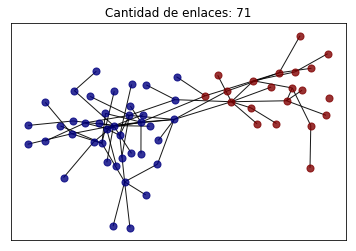

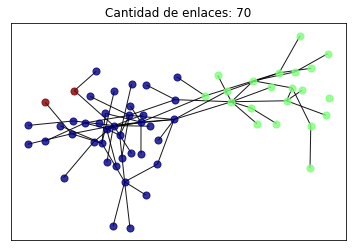

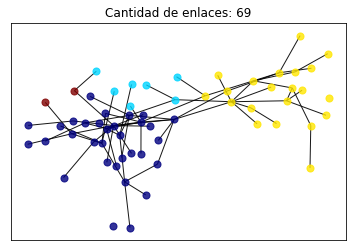

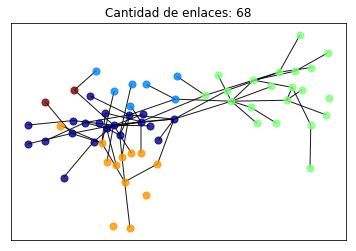

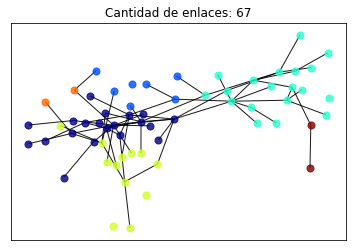

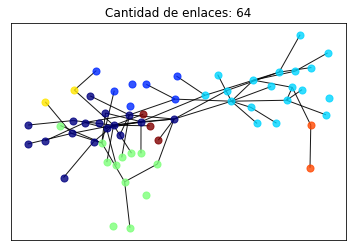

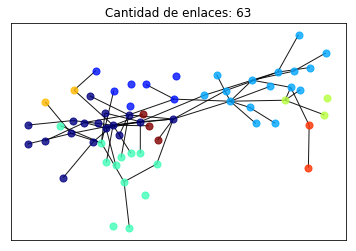

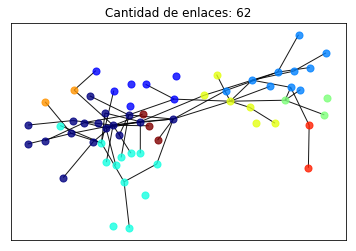

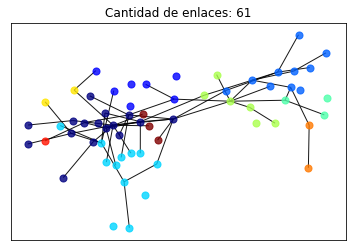

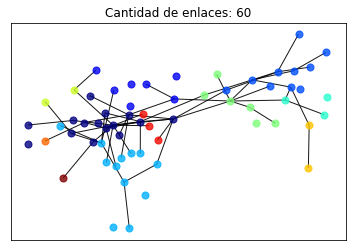

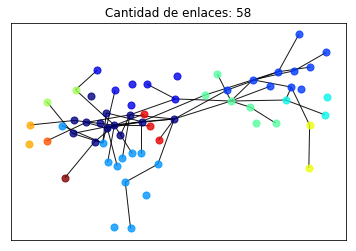

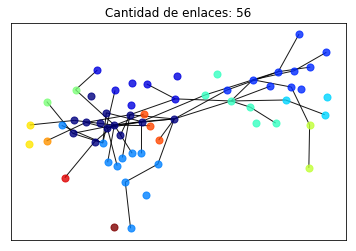

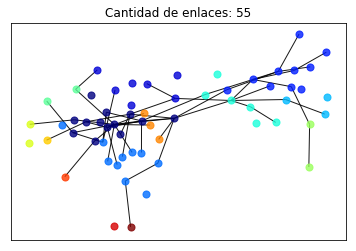

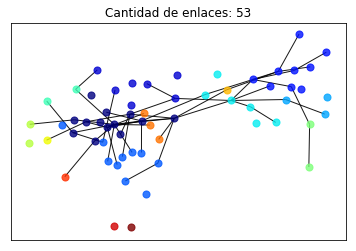

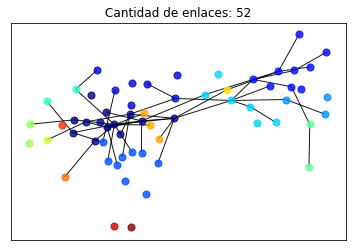

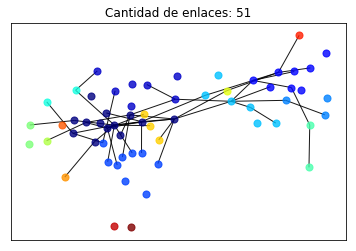

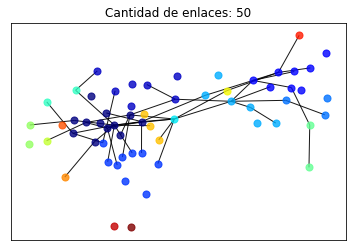

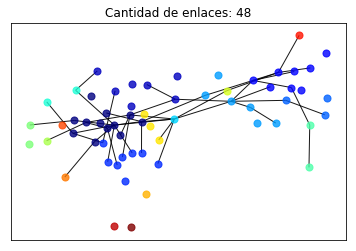

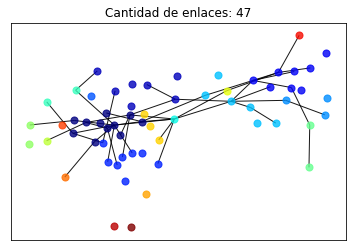

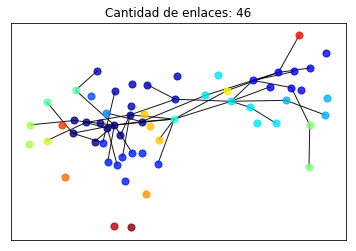

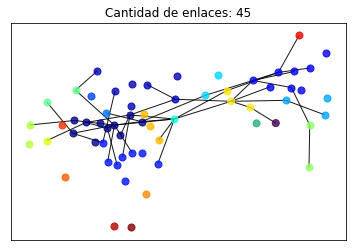

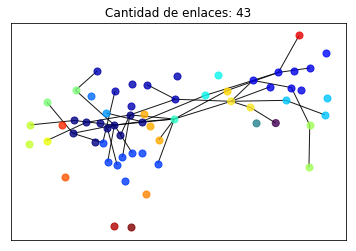

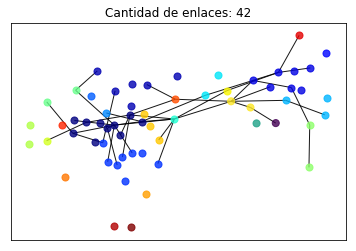

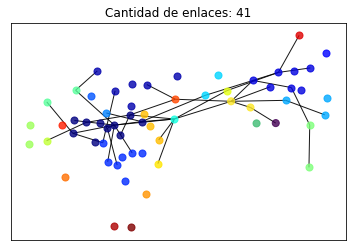

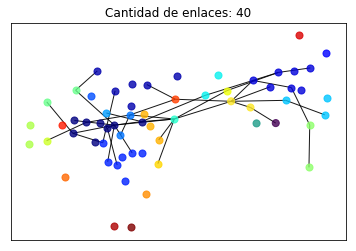

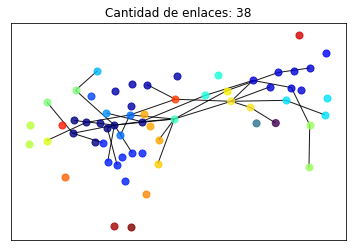

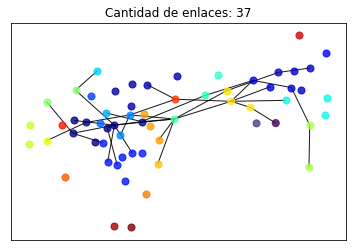

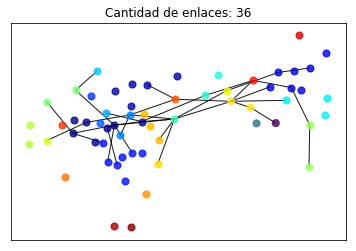

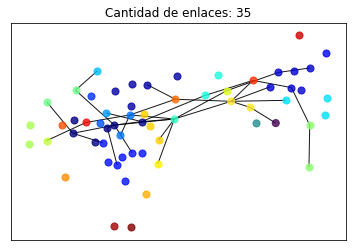

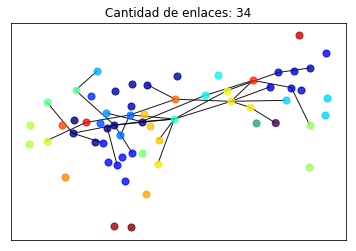

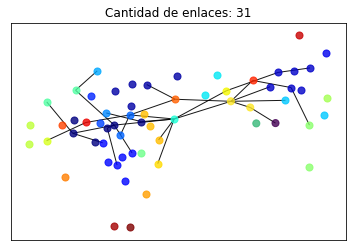

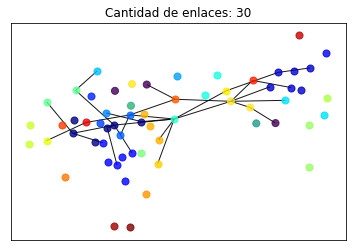

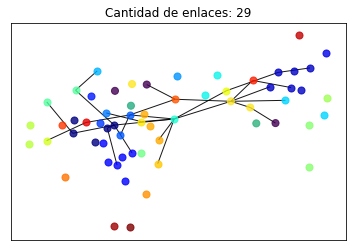

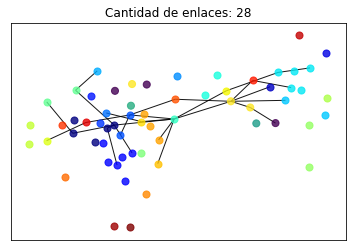

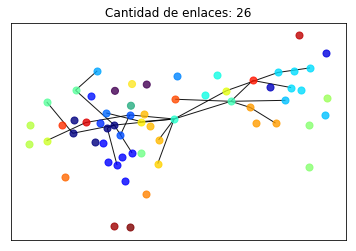

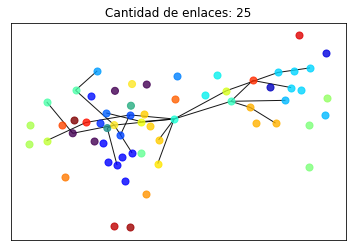

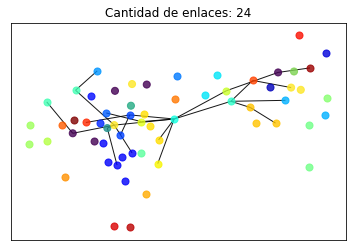

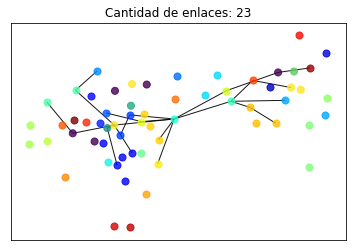

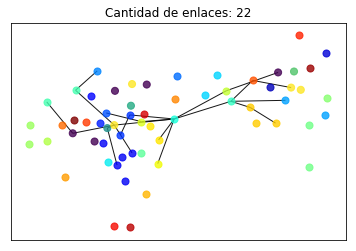

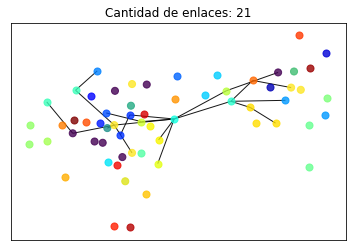

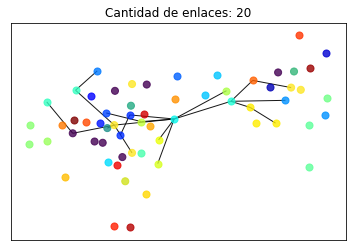

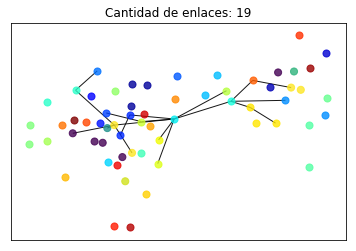

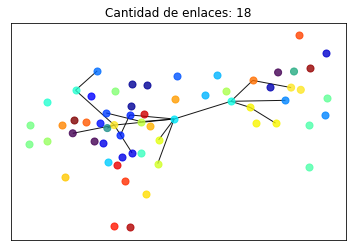

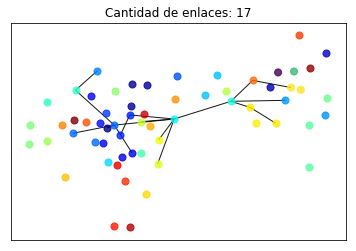

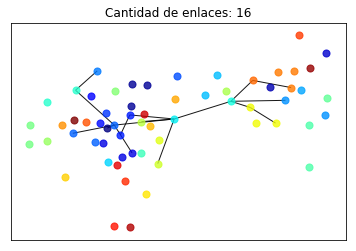

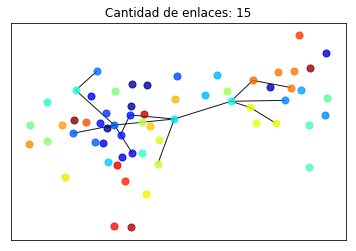

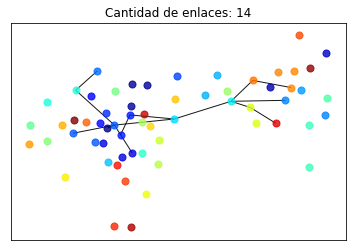

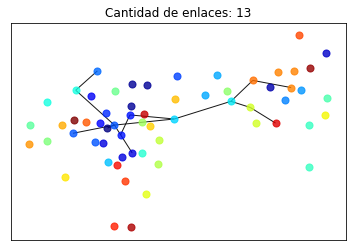

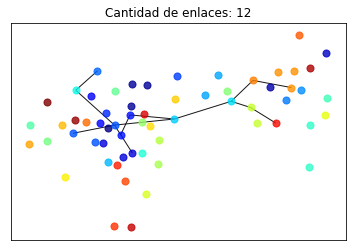

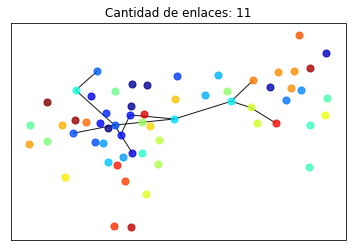

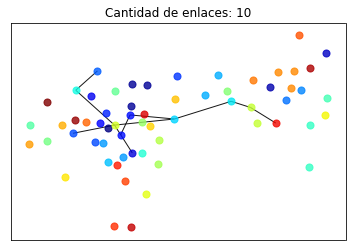

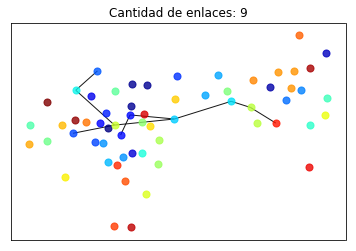

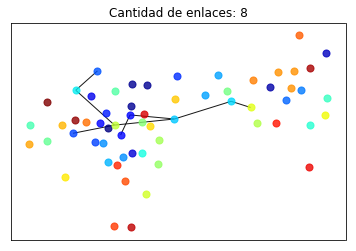

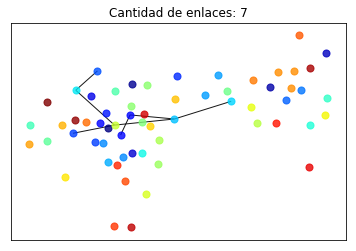

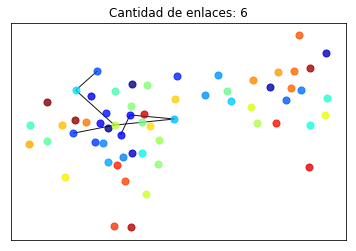

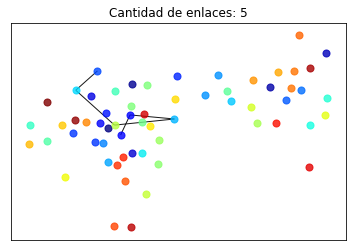

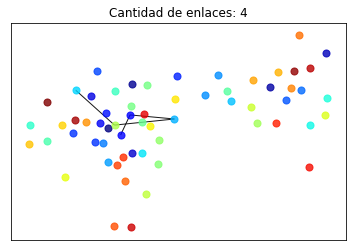

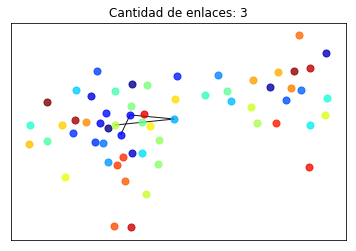

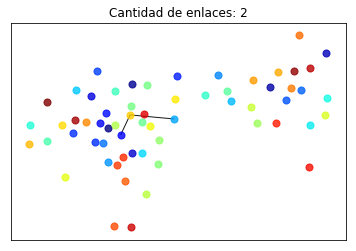

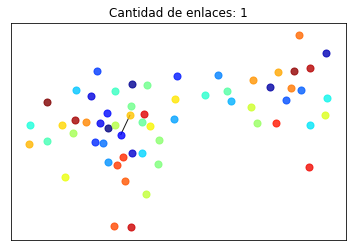

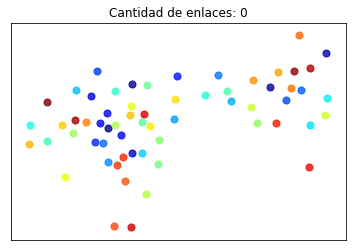

In [8]:
# Para graficar las comunidades por colores, eliminando enlaces
G_copy = nx.read_gml(carpeta+'dolphins.gml') # Creo una copia para tener la copia original intacta

for d,g in zip(delfines,genero):
    G_copy.add_node(d, gender=g)

print('Cantidad de enlaces original: '+str(G_copy.number_of_edges()))
it = len(a)

for j in range(it):
    coms = a[j]
    N = len(coms)
    colores_com = np.linspace(0,1,N)
    colores = [ cm.jet(x) for x in colores_com ]
    
    for i in range(N):
        nx.draw_networkx_nodes(G_copy,pos,nodelist=coms[i],
                               node_color=colores[i],with_labels=False,node_size=50,alpha=0.8)
    
    n = nx.number_connected_components(G_copy)
    while nx.number_connected_components(G_copy)==n:
        eb = nx.edge_betweenness_centrality(G_copy) # Diccionario con enlaces y correspondiente edge betweenness
        borrar = sorted(eb, key=eb.__getitem__) # Lista de enlaces de mayor a menor edge betweenness
        G_copy.remove_edge(*borrar[0])
        if G_copy.number_of_edges()==0:
            break
    
    enlaces = list(G_copy.edges())
    nx.draw_networkx_edges(G_copy,pos,edgelist=enlaces,alpha=0.9)
    plt.title('Cantidad de enlaces: '+ str(G_copy.number_of_edges()))
    plt.xticks([])
    plt.yticks([])
    plt.show()


## Modularidad y silhouette
En el caso de edge-betweenness, obtengo todas las posibles separaciones en comunidades, no solo la mejor. Por eso es necesario utilizar algun criterio para decidir cual es la optima.

El paso con el valor maximo de modularidad es el 3, con una modularidad de 0.519


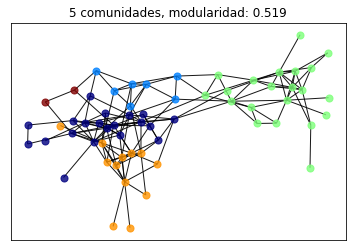

In [9]:
# Calculo de modularidad

delfines = G.nodes()
A = np.array(nx.to_numpy_matrix(G,nodelist=delfines)) # Creo la matriz de adyacencia
m = G.number_of_edges()
grado = dict(G.degree())

it = len(a)
mod = np.zeros(it) # Es un vector de longitud = cantidad de pasos, porque calculo la modularidad para cada uno de ellos

for j in range(it):
    coms = a[j]
    
    # Agrego el atributo de a que comunidad pertenece cada delfin, para cada paso it
    for c,comunidad in enumerate(coms):
        for delfin in list(comunidad):
            G.node[delfin]['community'] = c

    # Matriz de variable categorica comunidad: Cij=delta(ci,cj), tengo una por paso
    C = np.zeros(np.shape(A))
    for ni, idelfin in enumerate(delfines):
        for nj, jdelfin in enumerate(delfines):
            if G.nodes[idelfin]['community']==G.nodes[jdelfin]['community']:
                C[ni,nj]=1

    # Calculo de la modularidad
    # Q/Qmax = (S1-S2)*(1/2m)

    #S1 = Suma en nodos (Aij*Cij)
    #S2 = Suma en nodos(kikj*Cij/2m)
    S1 = 0
    S2 = 0

    for ni, idelfin in enumerate(delfines):
        for nj, jdelfin in enumerate(delfines):  
            S1 = S1 + A[ni,nj]*C[ni,nj]
            S2 = S2 + grado[idelfin]*grado[jdelfin]*C[ni,nj]
    S2 = S2/(2*m)
    mod[j] = (S1-S2)/(2*m)

# Ahora que tengo el vector modularidad con el valor para cada paso, busco el maximo para saber cual es la particion optima

indice = np.argmax(mod) # El indice del valor maximo
mod_max = max(mod) # El valor maximo de modularidad

print('El paso con el valor maximo de modularidad es el '+ str(indice) +', con una modularidad de %.3f' %mod_max)

# Ahora grafico la separacion en comunidades correspondiente a esos valores
coms = a[indice]
N = len(coms)
colores_com = np.linspace(0,1,N)
colores = [ cm.jet(x) for x in colores_com ]

for i in range(N):
    nx.draw_networkx_nodes(G,pos,nodelist=coms[i],
                           node_color=colores[i],with_labels=False,node_size=50,alpha=0.8)

enlaces = list(G.edges())
nx.draw_networkx_edges(G,pos,edgelist=enlaces,alpha=0.9)
plt.title(str(N)+' comunidades, modularidad: %1.3f' %mod_max)
plt.xticks([])
plt.yticks([])
plt.show()

Silhouette promedio: 0.34


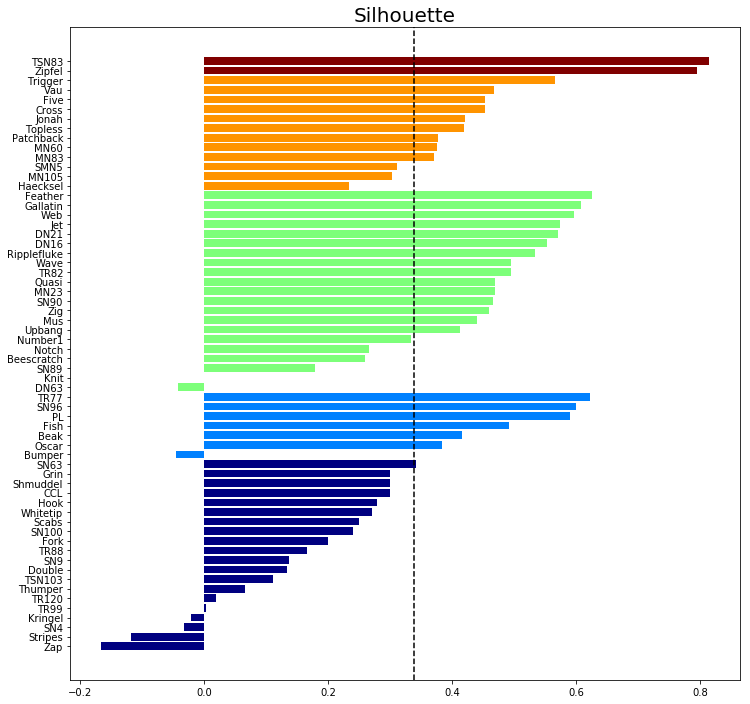

In [20]:
# silhouette: s = (b-a)/max(a,b) 
# donde a es promedio en el mismo cluster y b es minima distancia promedio con otros clusters

# Calculo de silhouette para la division en 5 comunidades
# Deberia calcular en cada division y ver que lo mejor sea en 5 comunidades?
coms = a[indice]
N = len(coms)
coms_nro = np.arange(N)
delfines = G.nodes()

a_s = np.zeros(len(delfines))
b_s = np.zeros(len(delfines))
s = np.zeros(len(delfines))

# Agrego el atributo de a que comunidad pertenece cada delfin
for c,comunidad in enumerate(coms):
    for delfin in list(comunidad):
        G.node[delfin]['community'] = c

# Calculo de a[i]
for i,idelfin in enumerate(delfines):
    distancias=[]
    for jdelfin in delfines:
        if G.nodes[idelfin]['community']==G.nodes[jdelfin]['community']:
               distancias.append(nx.shortest_path_length(G,idelfin,jdelfin))
    a_s[i] = np.mean(distancias)

# Calculo de b[i]
for i,idelfin in enumerate(delfines): 
    #Me quedo con las comunidades distintas a la del delfin idelfin
    comuni = list(coms_nro)
    comuni.remove(G.node[idelfin]['community'])
    b_comuni = []
    for c in comuni:
        distancias=[]
        for jdelfin in delfines:
            if G.nodes[jdelfin]['community']==c:
                distancias.append(nx.shortest_path_length(G,idelfin,jdelfin))
        promedio_comuni = np.mean(distancias)
        b_comuni.append(promedio_comuni)
    b_s[i] = min(b_comuni)

# Calculo el Silhouette:
for i,idelfin in enumerate(delfines):
    s[i] = (b_s[i]-a_s[i])/(max(b_s[i],a_s[i]))
    #guardo la propiedad silhouette en el grafo:
    G.node[idelfin]['silhouette'] = s[i]

df = pd.DataFrame.from_dict(dict(G.nodes.data('silhouette')), orient="index")
#df # Si quiero ver la tabla con los valores

silhouette_mean = np.mean(s)
print('Silhouette promedio: %.2f'%silhouette_mean)

# Grafico de Silhouette:
width = 12
height = 12
plt.figure(figsize=(width, height))

y = []
yTicks = []
contador = -1
dtype = [('name', 'S21'), ('silhouette', float)]
delfines = np.sort(delfines)

for c,color in enumerate(colores):
    delf_S = [] #lista con pares de [delfin,silouette]
    for i, idelfin in enumerate(delfines):
        if G.nodes[idelfin]['community']==c:
            delf_S.append((str(idelfin),G.nodes[idelfin]['silhouette']))        
    delf_S = np.array(delf_S,dtype=dtype)
    delf_S = np.sort(delf_S,order='silhouette') #lo ordeno segun la propiedad silhouette
    delf_S = list(delf_S)
    for j,d in enumerate(delf_S):
        contador = contador+1
        delfin = str(delf_S[j][0],'utf-8')
        silhouette_value = delf_S[j][1]
        plt.barh(contador,silhouette_value,color=color)#grafico una barra
        y.append(contador)
        yTicks.append(delfin)

plt.yticks(y, yTicks)
plt.yticks(range(len(delfines)),yTicks)

# Agrego el valor promedio como una linea vertical
plt.axvline(silhouette_mean, c='k', linestyle='--')

plt.title('Silhouette',fontsize=20)
#plt.savefig('silhouette_edgebetweenness.png')
plt.show()


In [16]:
#------------------------------------------------------------------------------
#1b) Rewirings:
#------------------------------------------------------------------------------
#Se podria tomar la red original recablear, y luego para las comunidades encontradas
#en la red original contar los enlaces que se hayan entre esos nodos.
#O sea estariamos calculando de forma simulada el valor kikj/2L.
#Haremos un histograma del numero de enlaces en esa comunidad.

from funciones import rewiring

iteraciones = 5000 #descomentar para que corra
Recableados = {}
#es un diccionario que tiene como keys ['comunidadi'] y como propiedades['color','lc_real','lc_random'].
#lc_random es una lista de tamano 'iteraciones' y que contiene el numero de enlaces dentro de esa comunidadn uno de esos recableados
lc_random = [[],[],[],[],[]]


#Recableamos y contamos enlaces en cada comunidad
for it in range(iteraciones):
    D = rewiring(G) #creamos un nuevo grafo recableado:
    D_ady = np.array(nx.to_numpy_matrix(D,nodelist=delfines))
    for c,comu in enumerate(coms):
        enlaces=0
        for idelfin in list(comu):
            for jdelfin in list(comu):
                #Buscamos los indices en la lista de delfines para luego acceder a la matrix de Ady con esos indices ni y nj:
                ni = [idx for idx,d in enumerate(delfines) if d==idelfin]
                nj = [idx for idx,d in enumerate(delfines) if d==jdelfin]
                enlaces = enlaces+D_ady[ni,nj]
        lc_random[c].append(int(enlaces)/2)
        Recableados['comunidad'+str(c)]={'color':colores[c],'lc_real':0,'lc_random':list(lc_random[c])}



NameError: name 'modularidad_rewiring' is not defined

/home/mluzv/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


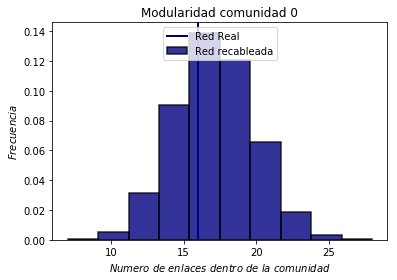

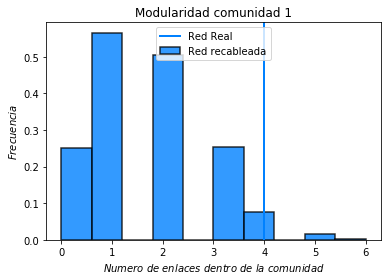

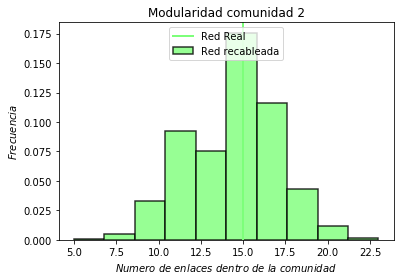

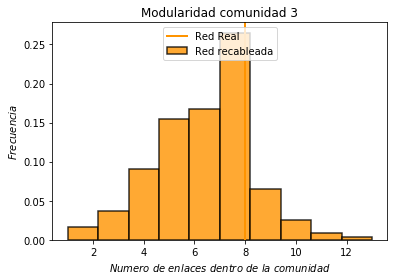

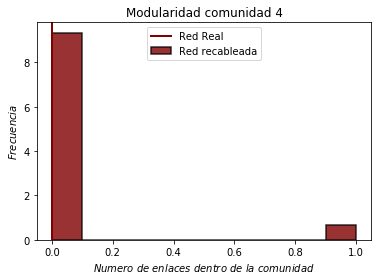

In [19]:
for c,comu in enumerate(coms):
        enlaces = 0
        for idelfin in list(comu):
            for jdelfin in list(comu):
                #Buscamos los indices en la lista de delfines para luego acceder a la matrix de Ady con esos indices ni y nj:
                ni = [idx for idx,d in enumerate(delfines) if d==idelfin]
                nj = [idx for idx,d in enumerate(delfines) if d==jdelfin]
                enlaces = enlaces+A[ni,nj]
        enlaces=int(enlaces)/2
        Recableados['comunidad'+str(c)]['lc_real']=enlaces

#Graficamos:

for c,comu in enumerate(coms):
    plt.figure(c)
    plt.hist(Recableados['comunidad'+str(c)]['lc_random'],color=colores[c],linewidth=1.5,edgecolor='black',label='Red recableada',alpha=0.8,normed=1)
    plt.axvline(x=Recableados['comunidad'+str(c)]['lc_real'],color=colores[c],linewidth=2,label='Red Real')
    plt.xlabel('$Numero$ $de$ $enlaces$ $dentro$ $de$ $la$ $comunidad$')
    plt.ylabel('$Frecuencia$')
    plt.legend(loc='upper center')
    plt.title('Modularidad comunidad '+str(c))
#    plt.savefig(outfolder+'comunidad_'+colores[c]+'_hist.png')

#Output
'''
for c,comu in enumerate(comunidades):
    lc_real=Recableados['comunidad'+str(c)]['lc_real'] #numero de enlaces dentro de la comunidad en la red real
    lc_rewiring=np.mean(Recableados['comunidad'+str(c)]['lc_random'])#numero de enlaces promedio dentro de la comunidad para un cierto numero de redes recableadas.
    modularidad_por_rewiring=(lc_real-lc_rewiring)/m #dividimos por el numero de enlaces totales.
    output={}
    output['comunidad']=Recableados['comunidad'+str(c)]['color']
    output['enlaces_red_real']=lc_real
    output['enlaces_red_recabelada']=lc_rewiring
    output['modularidad por rewiring']=modularidad_por_rewiring
    output['modularidad por cuenta teorica']=modularidades[c]
    output['enlaces_red_random']=list(Recableados['comunidad'+str(c)]['lc_random'])
    df = pd.DataFrame.from_dict(output, orient="index")
    df.to_csv(outfolder+'comunidad_'+colores[c]+'_data.txt',sep='\t')
'''